# Dynamics of quantum walk on glued tree

In [2]:
from glue_tree import *

Generating glued tree with depth 3
Each tree has 15 vertices
Total number of vertices: 30

Glued connections between leaves:
  Leaf 7 (Tree 0) ↔ Leaf 28 (Tree 1)
  Leaf 28 (Tree 0) ↔ Leaf 8 (Tree 1)
  Leaf 8 (Tree 0) ↔ Leaf 27 (Tree 1)
  Leaf 27 (Tree 0) ↔ Leaf 9 (Tree 1)
  Leaf 9 (Tree 0) ↔ Leaf 26 (Tree 1)
  Leaf 26 (Tree 0) ↔ Leaf 10 (Tree 1)
  Leaf 10 (Tree 0) ↔ Leaf 25 (Tree 1)
  Leaf 25 (Tree 0) ↔ Leaf 11 (Tree 1)
  Leaf 11 (Tree 0) ↔ Leaf 22 (Tree 1)
  Leaf 22 (Tree 0) ↔ Leaf 12 (Tree 1)
  Leaf 12 (Tree 0) ↔ Leaf 29 (Tree 1)
  Leaf 29 (Tree 0) ↔ Leaf 13 (Tree 1)
  Leaf 13 (Tree 0) ↔ Leaf 24 (Tree 1)
  Leaf 24 (Tree 0) ↔ Leaf 14 (Tree 1)
  Leaf 14 (Tree 0) ↔ Leaf 23 (Tree 1)
  Leaf 23 (Tree 0) ↔ Leaf 7 (Tree 1)

Hamiltonian (Adjacency Matrix):
 0: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 1: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 2: [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 3: [0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0

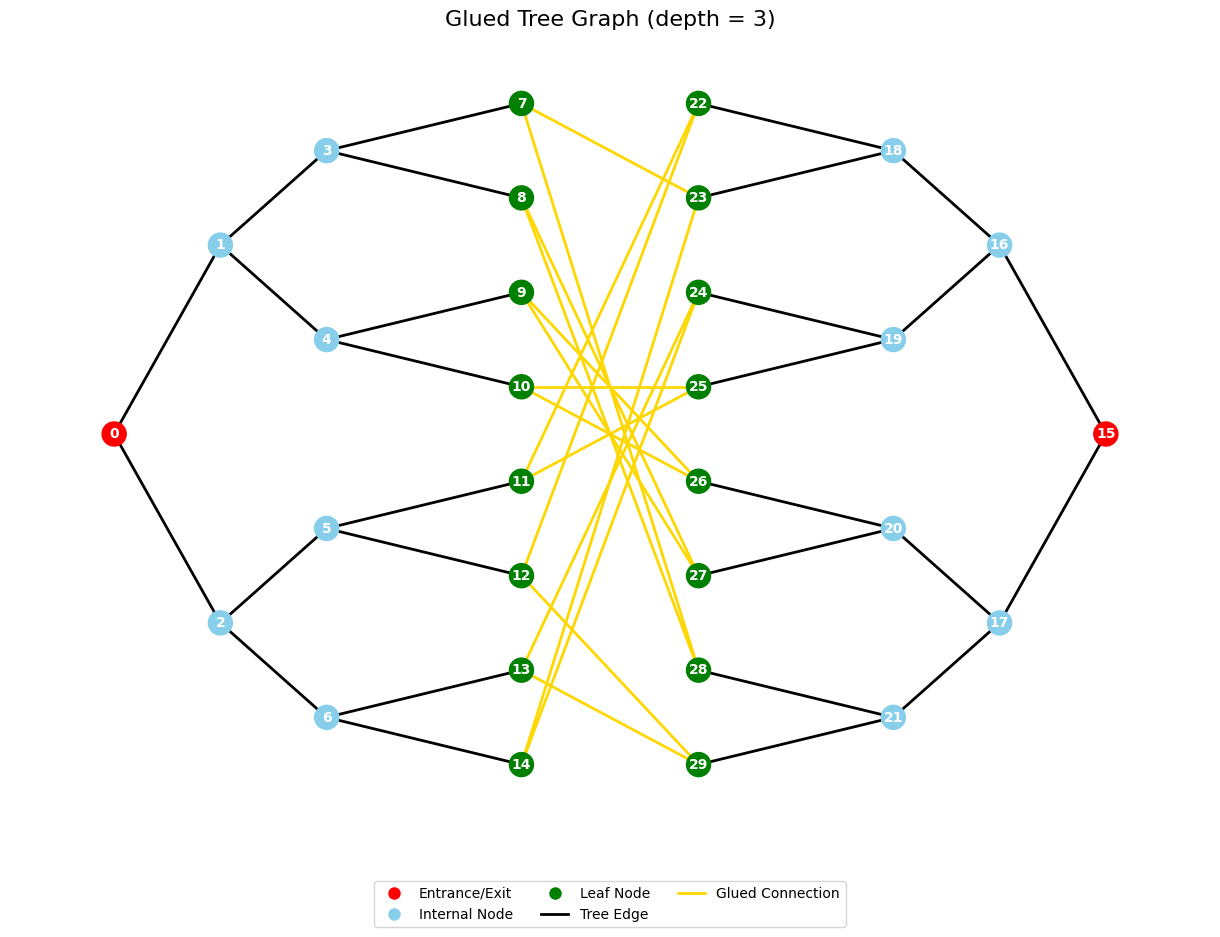

In [3]:
# Example usage
# Generate a Hamiltonian for a glued tree with depth 2
depth = 3
H = generate_glued_tree_hamiltonian(depth=depth)
# H = generate_glued_tree_hamiltonian(depth=depth, seed=42)

# Print the Hamiltonian
print_hamiltonian(H)

# Convert the Hamiltonian to a graph
G = hamiltonian_to_graph(H)

# Identify important components of the graph
components = identify_graph_components(H, depth)
print("\nGraph Components:")
print(f"  Entrance: {components['entrance']}")
print(f"  Exit: {components['exit']}")
print(f"  Tree 0 Leaves: {components['tree0_leaves']}")
print(f"  Tree 1 Leaves: {components['tree1_leaves']}")
print("  Glued Connections:")
for leaf0, leaf1 in components['glued_pairs']:
    print(f"    {leaf0} ↔ {leaf1}")

# Visualize the graph
visualize_glued_tree_graph(G, depth, save_file=f"./figs/childs_glued_tree_depth_{depth}.pdf")

In [4]:
from qiskit.quantum_info import Statevector
import numpy as np

dim = len(H)
# print(dim)
init_state = dim * [0]
init_state[0] = 1

t_list = np.linspace(0, 5, 100)
amp_entr = [expH(H, t).dot(init_state)[0] for t in t_list]
amp_exit = [expH(H, t).dot(init_state)[15] for t in t_list] # 15 is the exit node in the glued tree with depth 3
amp_midd = [expH(H, t).dot(init_state)[22] for t in t_list] # 22 is the middle node in the glued tree with depth 3

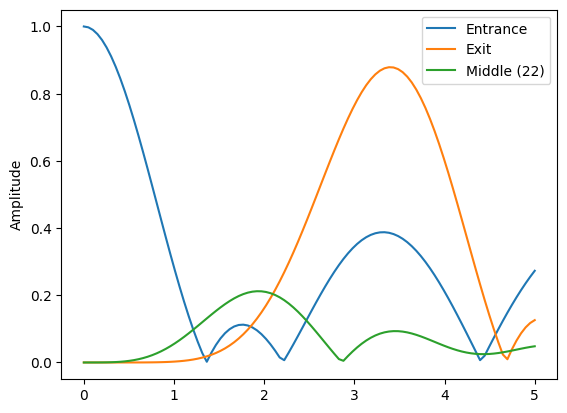

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(t_list, np.abs(amp_entr), label='Entrance')
axes.plot(t_list, np.abs(amp_exit), label='Exit')
axes.plot(t_list, np.abs(amp_midd), label='Middle (22)')
axes.set_ylabel('Amplitude')
axes.legend()

fig.savefig(f'./figs/childs_glued_tree_depth_{depth}_dqpt_middle.pdf')

## [todo] recover Childs Thesis figure.5-4 Prob V.S. columns at three different timesteps (check the propogation)

In [40]:
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy, schmidt_decomposition
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import svd

In [94]:
def evolve(H: csr_matrix, n: int, t: float):
    N = 2*n + 1
    psi0 = np.zeros(N, dtype=complex)
    psi0[0] = 1.0
    psi_t = expm_multiply(-1j * H, psi0, start=0.0, stop=t, num=2)[-1]
    evolve_entropy(H, psi0, t) 
    return np.abs(psi_t)**2

def vn_entropy(psi: np.ndarray, dims: (int, int)):
    dA, dB = dims
    psi_matrix = psi.reshape(dA, dB)
    # Singular values = Schmidt coefficients
    U, D, Vt = svd(psi_matrix, full_matrices=False)
    D = D / np.linalg.norm(D)
    l = D**2
    S = -np.sum(l * np.log(l) / np.log(2))
    return S

def evolve_entropy(L: csr_matrix, psi: np.ndarray, t: float):
    entropy_list = [] 
    t_list = np.linspace(0, t, t) 
    
    for t in t_list: 
        psi_t = expm_multiply(-1j * L * t, psi)
        S = vn_entropy(psi_t, (77, 13))
        entropy_list.append(S)
    
    plt.plot(t_list, entropy_list, label='entropy')
        
    plt.xlabel(rf'Evolution Time $t$')
    plt.ylabel('Entanglement entropy')
    plt.show()

def plot_prob(probs, n, t):
    x = np.arange(0, 2*n+1)
    plt.plot(x, probs, linewidth=0.5)
    plt.xlabel("column")
    plt.ylabel("probability")
    plt.title(f" t={int(t)}")
    plt.xlim(0, 2*n)
    plt.margins(y=0)
    plt.show()


In [91]:
def column_laplacian_H(n: int) -> csr_matrix:
    N = 2*n + 1
    off = np.full(N-1, -np.sqrt(2.0), dtype=float)
    # print(off)
    A = diags([off, off], offsets=[-1,1], shape=(N,N), format="csr")
    degrees = np.zeros(N, dtype=float)
    degrees[:] = 3
    degrees[0], degrees[n], degrees[N-1] = 2, 2, 2
    D = diags([degrees], [0], shape=(N,N), format="csr")
    # print(A+D)
    return (A + D).tocsr()

S(rho)= -Tr[rho log rho] = - \sum (lambda_i * log lambda_i)

\psi = U @ diag(s) @ V

/tmp/ipykernel_1444/725280426.py:38: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(l * np.log(l) / np.log(2))
/tmp/ipykernel_1444/725280426.py:38: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(l * np.log(l) / np.log(2))


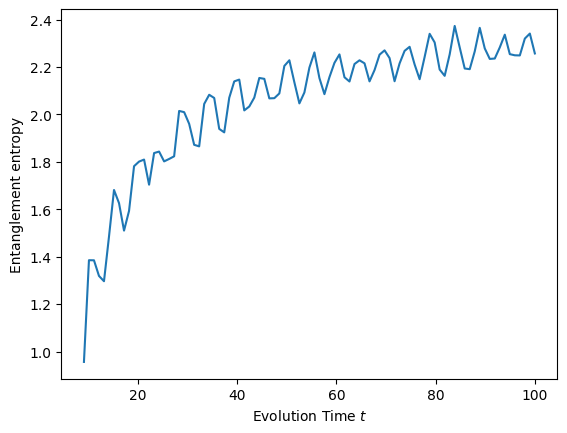

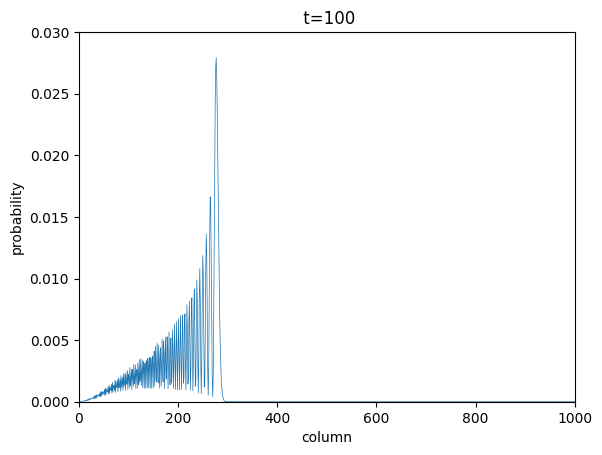

In [75]:
n = 500
# H = column_A(n)
H = column_laplacian_H(n)
p = evolve(H, n, 100)

x = np.arange(0, 2*n+1)
plt.plot(x, p, linewidth=0.5)
plt.xlabel("column")
plt.ylabel("probability")
plt.title(f" t={int(100)}")
plt.xlim(0, 2*n)
plt.margins(y=0) 
plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03])
plt.show()


/tmp/ipykernel_1444/3235741574.py:38: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(l * np.log(l) / np.log(2))
/tmp/ipykernel_1444/3235741574.py:38: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(l * np.log(l) / np.log(2))


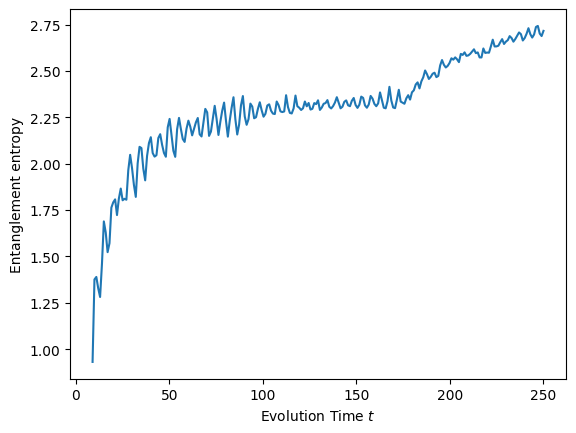

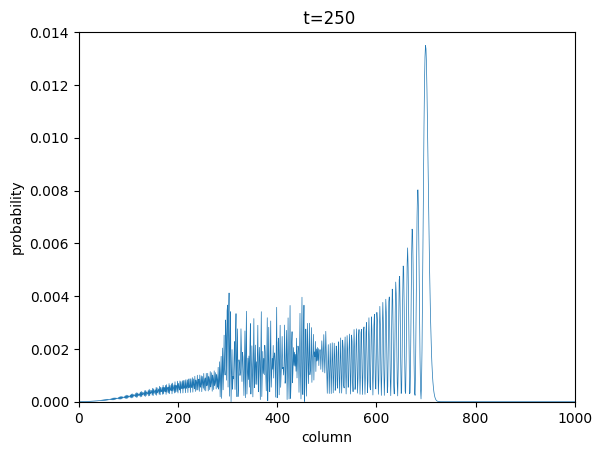

In [70]:
n = 500

# H = column_A(n)
H = column_laplacian_H(n)
p = evolve(H, n, 250)

x = np.arange(0, 2*n+1)
plt.plot(x, p, linewidth=0.5)
plt.xlabel("column")
plt.ylabel("probability")
plt.title(f" t={int(250)}")
plt.xlim(0, 2*n)
plt.margins(y=0) 
plt.yticks([0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014])
plt.show()


/tmp/ipykernel_1444/3235741574.py:38: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(l * np.log(l) / np.log(2))
/tmp/ipykernel_1444/3235741574.py:38: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(l * np.log(l) / np.log(2))


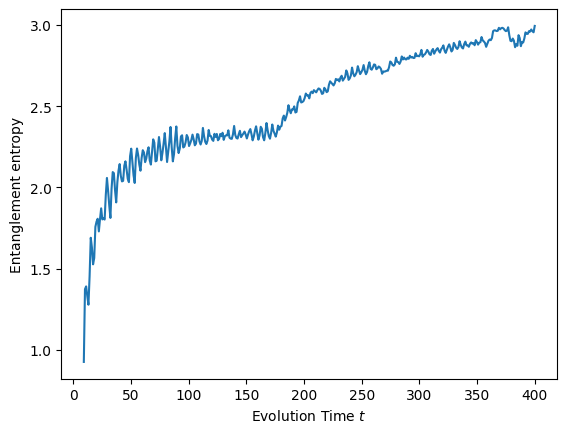

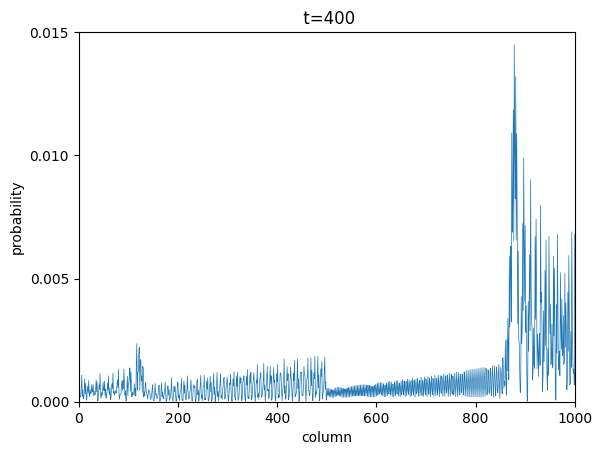

In [72]:
n = 500

H = column_laplacian_H(n)
# print(H)
p = evolve(H, n, 400)

x = np.arange(0, 2*n+1)
plt.plot(x, p, linewidth=0.5)
plt.xlabel("column")
plt.ylabel("probability")
plt.title(f" t={int(400)}")
plt.xlim(0, 2*n)
plt.margins(y=0) 
plt.yticks([0, 0.005, 0.01, 0.015])
plt.show()


In [11]:
from glue_tree_prime import *

Generating glued tree with depth 3
Each tree has 15 vertices
Total number of vertices: 30

Glued connections between leaves:
  Leaf 11 (Tree 0) ↔ Leaf 29 (Tree 1)
  Leaf 29 (Tree 0) ↔ Leaf 13 (Tree 1)
  Leaf 13 (Tree 0) ↔ Leaf 23 (Tree 1)
  Leaf 23 (Tree 0) ↔ Leaf 7 (Tree 1)
  Leaf 7 (Tree 0) ↔ Leaf 22 (Tree 1)
  Leaf 22 (Tree 0) ↔ Leaf 9 (Tree 1)
  Leaf 9 (Tree 0) ↔ Leaf 27 (Tree 1)
  Leaf 27 (Tree 0) ↔ Leaf 8 (Tree 1)
  Leaf 8 (Tree 0) ↔ Leaf 26 (Tree 1)
  Leaf 26 (Tree 0) ↔ Leaf 14 (Tree 1)
  Leaf 14 (Tree 0) ↔ Leaf 24 (Tree 1)
  Leaf 24 (Tree 0) ↔ Leaf 10 (Tree 1)
  Leaf 10 (Tree 0) ↔ Leaf 28 (Tree 1)
  Leaf 28 (Tree 0) ↔ Leaf 12 (Tree 1)
  Leaf 12 (Tree 0) ↔ Leaf 25 (Tree 1)
  Leaf 25 (Tree 0) ↔ Leaf 11 (Tree 1)

Hamiltonian (Adjacency Matrix):
 0: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 1: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 2: [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 3: [0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0

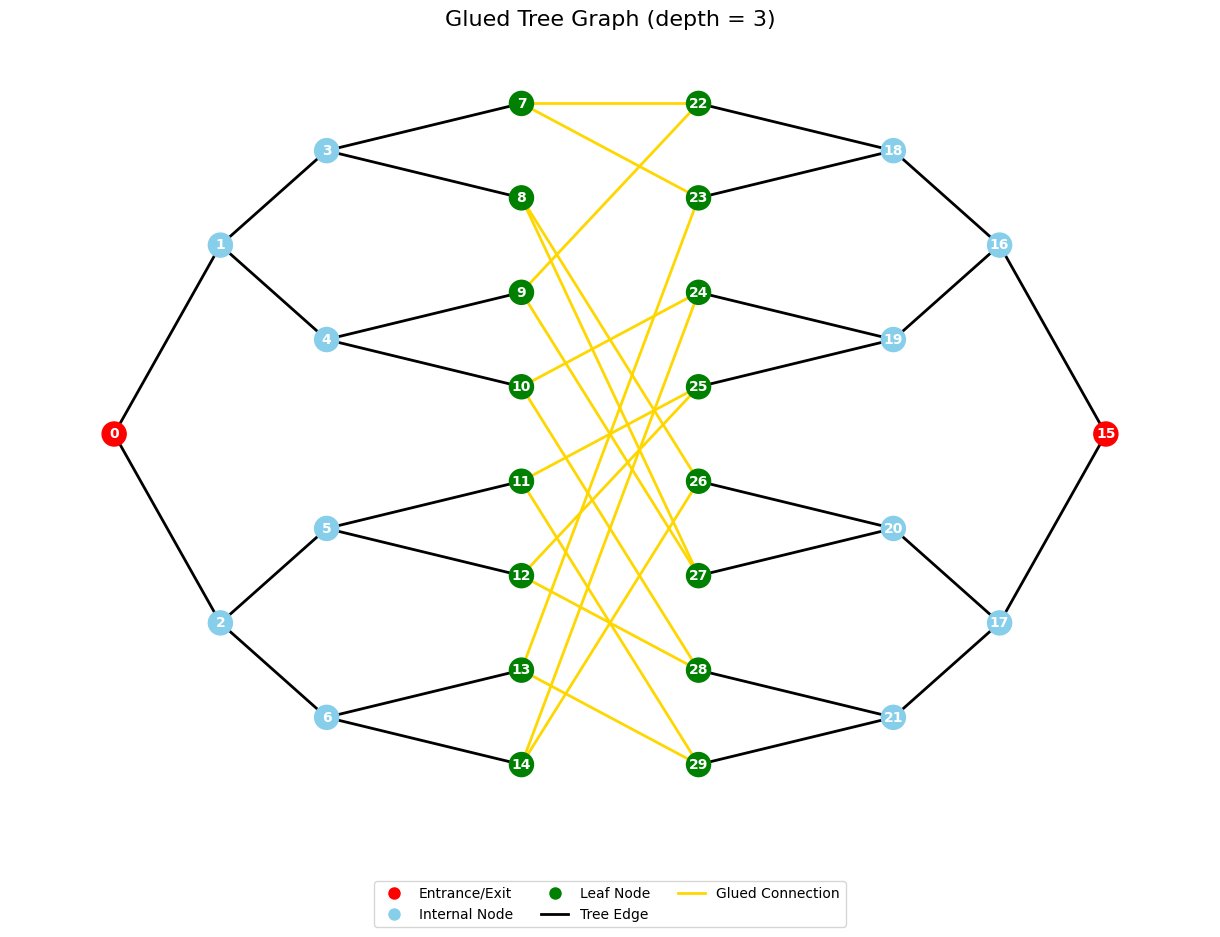

In [12]:
# Example usage
# Generate a Hamiltonian for a glued tree prime with depth 3
depth = 3
H = generate_glued_tree_hamiltonian_prime(depth=depth)
# H = generate_glued_tree_hamiltonian(depth=depth, seed=42)

# Print the Hamiltonian
print_hamiltonian(H)

# Convert the Hamiltonian to a graph
G = hamiltonian_to_graph(H)

# Identify important components of the graph
components = identify_graph_components(H, depth)
print("\nGraph Components:")
print(f"  Entrance: {components['entrance']}")
print(f"  Exit: {components['exit']}")
print(f"  Tree 0 Leaves: {components['tree0_leaves']}")
print(f"  Tree 1 Leaves: {components['tree1_leaves']}")
print("  Glued Connections:")
for leaf0, leaf1 in components['glued_pairs']:
    print(f"    {leaf0} ↔ {leaf1}")

# Visualize the graph
visualize_glued_tree_graph(G, depth, save_file=f"./figs/childs_glued_tree_depth_{depth}.pdf")

In [92]:
def column_A(n):
    N = 2*n + 1
    off = np.full(N-1, np.sqrt(2.0), dtype=float)
    off[n] = 2.0       
    A = diags([off, off], offsets=[-1, 1], shape=(N, N), format="csr")
    gamma = 1.0 / np.sqrt(2)
    return A * gamma

/tmp/ipykernel_1444/3059640753.py:16: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(l * np.log(l) / np.log(2))
/tmp/ipykernel_1444/3059640753.py:16: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(l * np.log(l) / np.log(2))


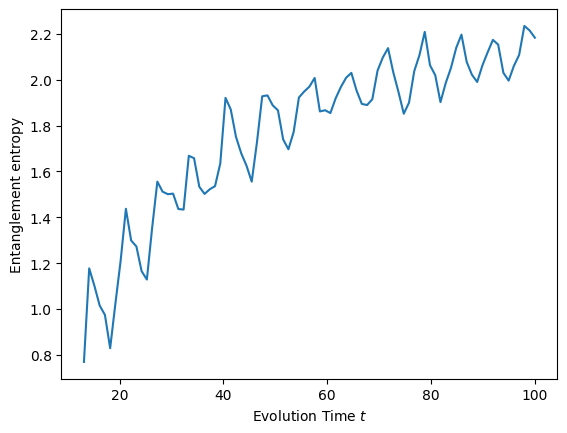

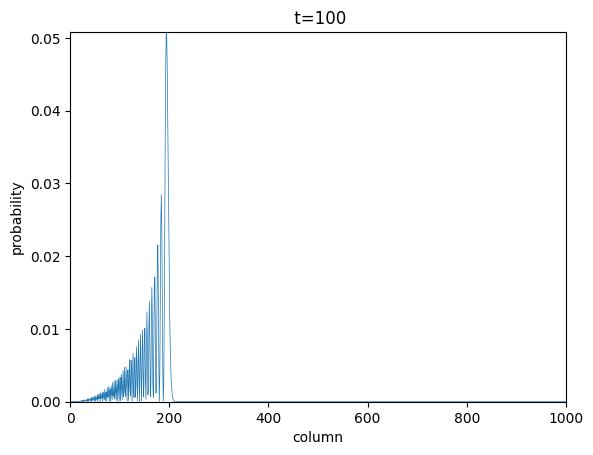

In [ ]:
n = 500
times = [100]  
for t in times: 
    H = column_A(n)
    p = evolve(H, n, t)
    plot_prob(p, n, t)

/tmp/ipykernel_1444/2273220042.py:24: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(l * np.log(l) / np.log(2))
/tmp/ipykernel_1444/2273220042.py:24: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(l * np.log(l) / np.log(2))


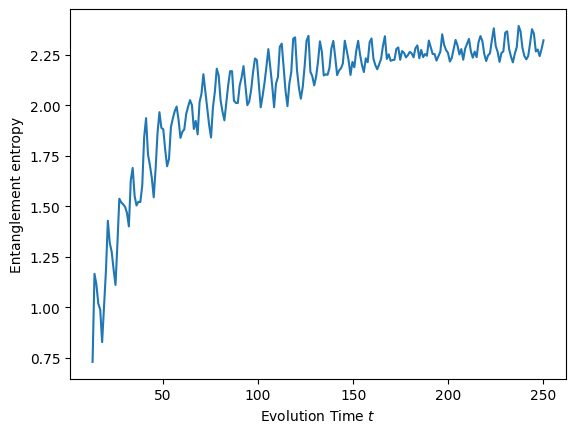

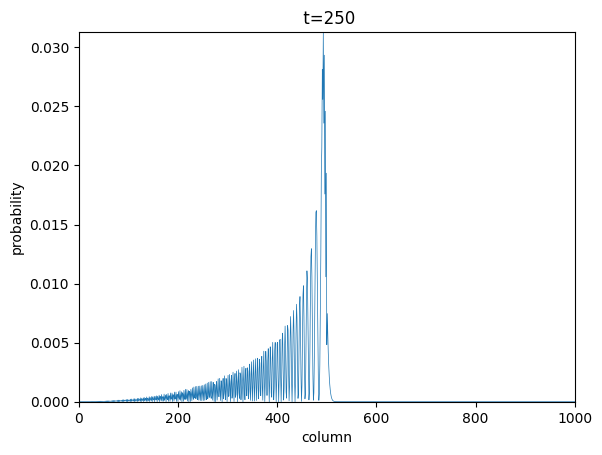

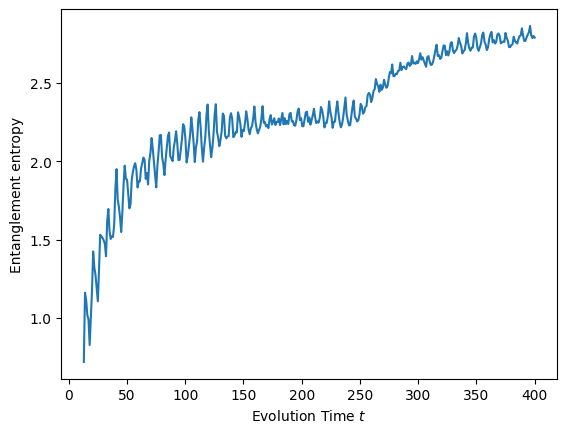

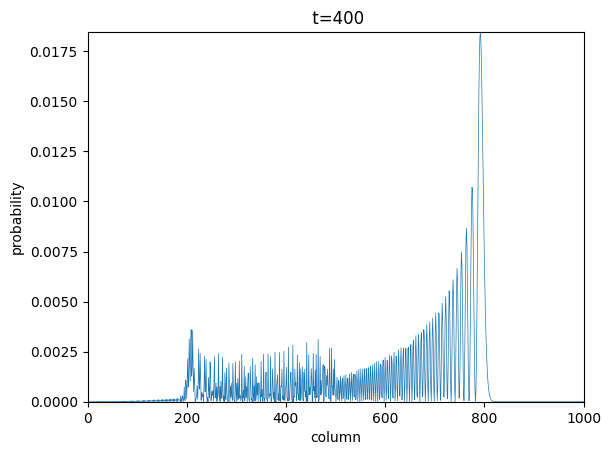

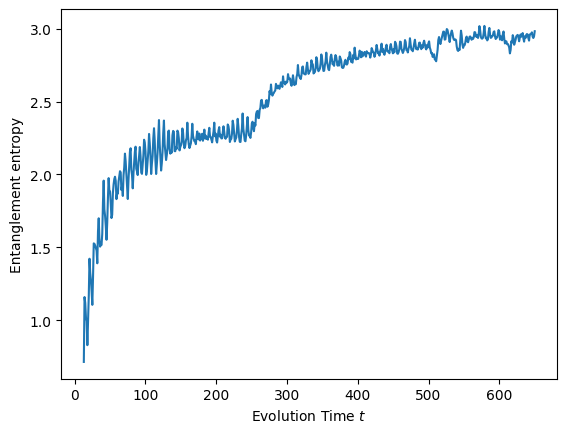

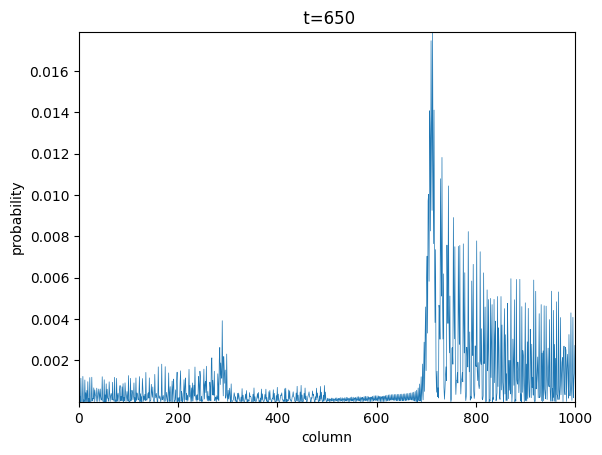

In [89]:
n = 500
times = [250, 400, 650] 
for t in times: 
    H = column_A(n)
    p = evolve(H, n, t)
    plot_prob(p, n, t)
